## Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# from tensorflow.keras import layers
# from tensorflow.keras import Model
# from tensorflow.keras import regularizers
# from tensorflow.keras.optimizers import RMSprop

pd.options.display.max_columns = 60
pd.options.display.max_rows = 600

## Data

In [2]:
def load_data():
    data = pd.read_csv('survey.csv')
    data.drop(columns='Informazioni cronologiche', inplace=True)

    data.dropna(inplace=True)
    df = pd.DataFrame()
    for n,i in enumerate(data.columns):
        df['ans_' + str(n)] = pd.Categorical(data[i]).codes

    df['ans_0'] = df['ans_0'].apply(lambda x: None if x==2 else x)
    df.dropna(inplace=True)

    cols = ['ans_' + str(i) for i in range(2,10)]
    for i in cols:
        df[i] = df[i] + 1
    val_ = df.loc[df['ans_0']==0].sample(len(df.loc[df['ans_0']==1])*2)
    val_.drop(columns=['ans_0', 'ans_1'], inplace=True)
    df.drop(val_.index, inplace=True, axis=0)
    eng = df.loc[df['ans_0']==0].sample(len(df.loc[df['ans_0']==1]), random_state=5)
    ita = df.loc[df['ans_0']==1]
    balanced_df_ = pd.concat([ita,eng])

    balanced_df_.reset_index(inplace=True)
    balanced_df_.drop(columns='index', inplace=True)
    val_.reset_index(inplace=True)
    val_.drop(columns='index', inplace=True)
    return balanced_df_, val_

In [3]:
def dummy(dataframe):
    cols = list(dataframe.columns)
    tmp = pd.DataFrame(dataframe['ans_3'])

    if 'ans_1' in cols:
        cols.remove('ans_1')
    if 'ans_0' in cols:
        cols.remove('ans_0')
        tmp = tmp.join(dataframe['ans_0'])

    for i in cols:
        tmp = tmp.join(pd.get_dummies(dataframe[i], prefix=i))
    
    tmp.drop(columns=['ans_3'], inplace=True)
    return tmp

In [4]:
def split_df(dataframe):
    if 'ans_0' in dataframe.columns:
        x = dataframe.drop(columns=['ans_0'])
        y = dataframe['ans_0']
    else:
        raise 'Mehnhhm'
    if 'ans_1' in dataframe.columns:
        x.drop(columns=['ans_1'], inplace=True)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=45)
    return x, y, x_train, x_test, y_train, y_test

In [5]:
def plot_ans():
    dataframe, _ = load_data()
    oldcols = ['Mothertongue ', 'Second Language',
    'You showed up an hour late for a dinner with your friends. ',
    'You borrowed your father’s keys but you lost them. Your father needs them back.',
    'You had just left the restaurant and you are checking the receipt, you noticed that you had paid less than you should have',
    'You were supposed to go to a friend’s graduation party but forgot to do so because you had a job interview.',
    'You accidentally run into the women’s toilet/men’s toilet while in a Pub.',
    "You are eating an ice cream in a crowed place and it falls on a stranger's shoe",
    'You had been      ',
    'You suggested an answer to a friend during an exam and you found out later that it was wrong']
    fig, axis = plt.subplots(2,4,figsize=(24,16))
    for i in range(8):
        if i % 2 == 0:
            k = 1
            j = i//2
        else:
            k = 0
            j = (i - 1)//2
            
        sns.violinplot(x='ans_0', y='ans_{}'.format(i+2), data=dataframe, ax=axis[k, j])
        axis[k,j].set_title(oldcols[i+2][:17])

        axis[k,j].set_xticklabels(['Inglesi', 'Italiani'], fontsize=14)
        axis[k,j].set_yticks(range(1,6))
        axis[k,j].set_xlabel('Nationality')
        axis[k,j].set_ylabel('Level of Offence')
        axis[k,j].tick_params(bottom=False, left=False)
        sns.despine(left=True, bottom=True)

## Anova

In [6]:
def anova():
    dataframe, _ = load_data()
    italians = dataframe.loc[dataframe['ans_0'] == 1].drop(columns=['ans_0', 'ans_1']).mean(axis=1)
    english = dataframe.loc[dataframe['ans_0'] == 0].drop(columns=['ans_0', 'ans_1']).sample(len(italians)).mean(axis=1)
    return stats.f_oneway(italians, english)

## Logistic Regression

In [7]:
def log_model(xtrain, ytrain, xtest, ytest, opt=None):
    lr = LogisticRegression( solver='lbfgs', multi_class='auto')
    lr.fit(xtrain, ytrain)

    predictions = lr.predict(xtest)
    return accuracy_score(ytest, predictions)

## K-Nearest Neighbours

In [8]:
def knn_model(xtrain, ytrain, xtest, ytest, opt):
    neigh = KNeighborsClassifier(n_neighbors=opt)
    neigh.fit(xtrain, ytrain)
    results = neigh.predict(xtest)
    return accuracy_score(ytest, results)

## Neural Net

In [9]:
def nn_model(xtrain, ytrain, xtest, ytest, opt):
    from sklearn.neural_network import MLPClassifier
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(opt), random_state=1)
    mlp.fit(xtrain, ytrain)
    predictions = mlp.predict(xtest).astype(int)
    return accuracy_score(ytest, predictions)

### Custom Neural Network Model

In [10]:
def create_model():
    # 76% accuracy
    input_layer = layers.Input(shape=(40))

    x = layers.Dense(4, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu')(input_layer)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(4, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(4, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(input_layer, output)


    model.compile(loss='binary_crossentropy',
              optimizer=('adam'),
              metrics=['acc']) 
    return model

In [11]:
def train_and_eval(model, xtrain, ytrain, xtest, ytest):
    model.fit(
            x = xtrain,
            steps_per_epoch=100,  
            epochs=40,
            y=ytrain,
            verbose=0)
    return model.evaluate(xtest, ytest)


def evaluate_model(model, xtrain, ytrain, xtest, ytest):
    hist = model.fit(
                    x = xtrain,
                    steps_per_epoch=50,  
                    epochs=40,
                    y=ytrain,
                    validation_data=(xtest, ytest),
                    batch_size=100,
                    verbose=0)
    return hist


In [12]:
def plot_model(history):
    # Retrieve a list of accuracy results on training and validation data
    # sets for each training epoch
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    # Retrieve a list of list results on training and validation data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')

    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')

In [13]:
def run_nn():
    n_folds = 5
    data, validation = load_data()
    validation_labels = np.zeros_like(validation['ans_2']).reshape(-1,1)
    validation = dummy(validation)
    data = dummy(data)
    x, y, x_train, x_test, y_train, y_test = split_df(data)
    sKFold = StratifiedKFold(n_folds, shuffle=True)
    mean_score = []
    for train, test in sKFold.split(x,y):
            model = None # Clearing the NN.
            model = create_model()
            results = train_and_eval(model, 
                                        x.loc[train], 
                                        y.loc[train], 
                                        x.loc[test], 
                                        y.loc[test])

            mean_score.append(results[1])
    print("Mean accuracy: ", np.mean(mean_score))


    model = None # Clearing the NN.
    model = create_model()
    histor = evaluate_model(model, x_train, y_train, x_test, y_test)
    plot_model(histor)
    return model.evaluate(validation, validation_labels)
## We actually had some issue here with the validation, I tried to use the data left out from the beginning sample
## So it didn't perform really well (nor that bad)

64/64 [==============================] - 1s 13ms/sample - loss: 2.5342 - acc: 0.6094
Mean accuracy:  0.596875
320/320 [==============================] - 0s 112us/sample - loss: 0.5127 - acc: 0.6844


[0.5126783877611161, 0.684375]

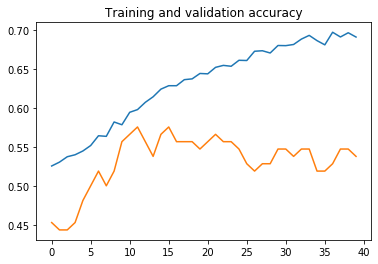

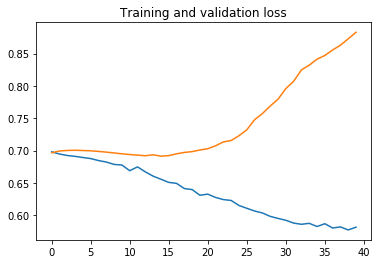

In [40]:
run_nn()

## Results

In [14]:
def run_model(model, n_folds=20, dum=True, opt=None):
    data, val = load_data()
    if dum:
        data = dummy(data)
    x, y, x_train, x_test, y_train, y_test = split_df(data)
    sKFold = StratifiedKFold(n_folds, shuffle=True)
    mean_score = []
    for train, test in sKFold.split(x,y):
            results = model(x.loc[train], 
                            y.loc[train], 
                            x.loc[test], 
                            y.loc[test],
                            opt=opt)
            
            mean_score.append(results)
    print("Mean accuracy: ", np.mean(mean_score))


In [15]:
run_model(log_model)

Mean accuracy:  0.60625


In [113]:
run_model(knn_model, dum=False, opt=7)

Mean accuracy:  0.59375


In [114]:
run_model(nn_model, opt=(5,4))

Mean accuracy:  0.575


In [33]:
anova()

F_onewayResult(statistic=9.71956768438831, pvalue=0.001989730869447628)

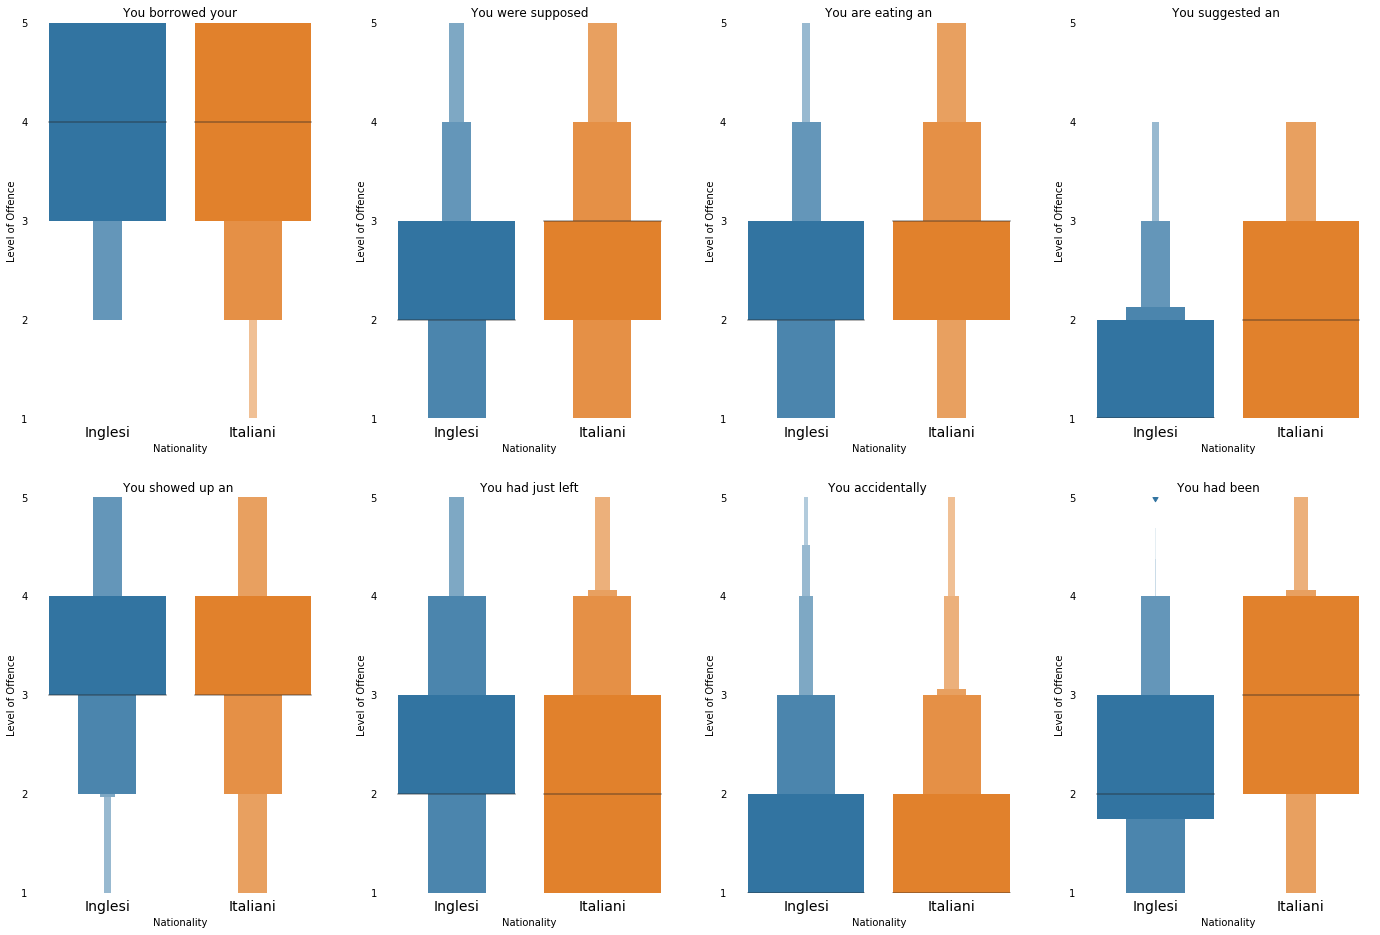

In [46]:
plot_ans()

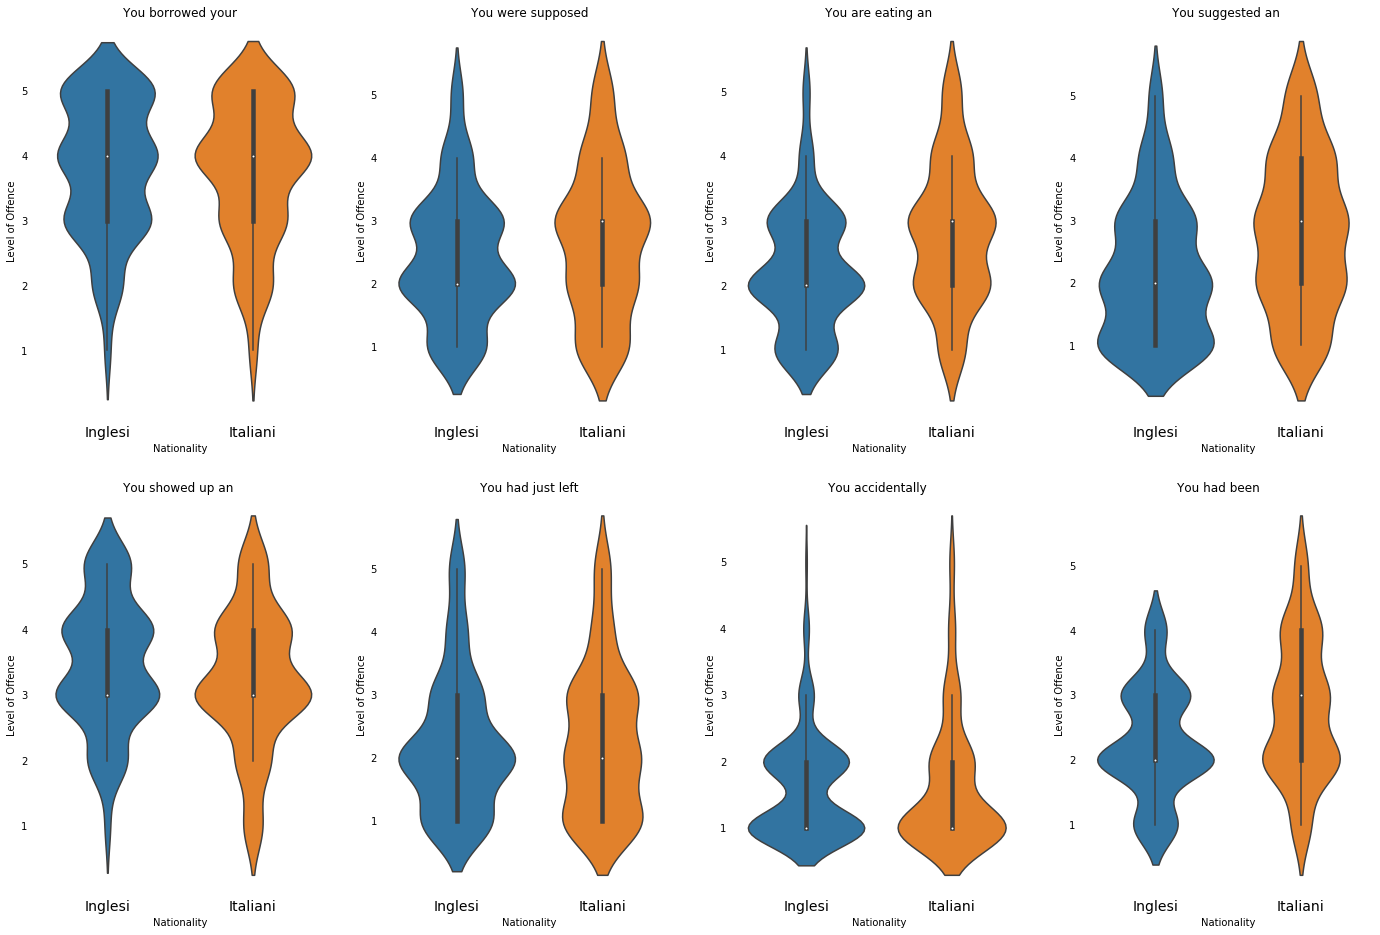

In [124]:
plot_ans()

In [16]:
dataframe, _ = load_data()
italians = dataframe.loc[dataframe['ans_0'] == 1].drop(columns=['ans_0', 'ans_1']).mean(axis=1)
english = dataframe.loc[dataframe['ans_0'] == 0].drop(columns=['ans_0', 'ans_1']).sample(len(italians)).mean(axis=1)
from scipy.stats import ttest_ind

ttest_ind(italians, english)

Ttest_indResult(statistic=3.0290822729005944, pvalue=0.002653978590382438)

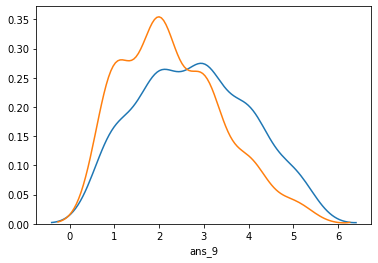

In [50]:
sns.distplot(italians, hist=False)
sns.distplot(english, hist=False)

In [44]:
print(italians.mean())
print(italians.std())
print(english.mean())
print(english.std())


2.7875
1.2151429245335814
2.3
1.0919948856055504


In [24]:
dataframe = data
cols = ['ans_' + str(i) for i in range(2,10)]
oldcols = ['Mothertongue ', 'Second Language',
    'You showed up an hour late for a dinner with your friends. ',
    'You borrowed your father’s keys but you lost them. Your father needs them back.',
    'You had just left the restaurant and you are checking the receipt, you noticed that you had paid less than you should have',
    'You were supposed to go to a friend’s graduation party but forgot to do so because you had a job interview.',
    'You accidentally run into the women’s toilet/men’s toilet while in a Pub.',
    "You are eating an ice cream in a crowed place and it falls on a stranger's shoe",
    'You had been      ',
    'You suggested an answer to a friend during an exam and you found out later that it was wrong']
for n, i in enumerate(cols):
    italians = dataframe.loc[dataframe['ans_0'] == 1].drop(columns=['ans_0', 'ans_1'])[i]
    english = dataframe.loc[dataframe['ans_0'] == 0].drop(columns=['ans_0', 'ans_1'])[i]
    print('Anova for ', oldcols[n+2][:17] , ': ', stats.f_oneway(italians, english),
          '\nCorrellation value r: ' + str(round(np.corrcoef(italians, english)[0][1], 4)))

Anova for  You showed up an  :  F_onewayResult(statistic=3.8843906427617014, pvalue=0.049603886789182094) 
Correllation value r: 0.0258
Anova for  You borrowed your :  F_onewayResult(statistic=0.18716892289582107, pvalue=0.6655766689307495) 
Correllation value r: -0.0937
Anova for  You had just left :  F_onewayResult(statistic=0.5873254069029206, pvalue=0.44402375284887696) 
Correllation value r: -0.0167
Anova for  You were supposed :  F_onewayResult(statistic=3.8181689006773087, pvalue=0.05157592508355656) 
Correllation value r: 0.0212
Anova for  You accidentally  :  F_onewayResult(statistic=0.5794503737309882, pvalue=0.44709194836985844) 
Correllation value r: -0.0498
Anova for  You are eating an :  F_onewayResult(statistic=11.281424756914705, pvalue=0.0008780394825174143) 
Correllation value r: -0.114
Anova for  You had been      :  F_onewayResult(statistic=12.680410106188209, pvalue=0.0004259797786032156) 
Correllation value r: -0.01
Anova for  You suggested an  :  F_onewayResult(s